In [1]:
import load
import oed
import figure

In [5]:
# jsonファイルの読み込み
result = load.load_result_json("../result/Result_biologically_correct.json")

gene = result[0]["gene"]

N, M, theta, w_on, w_off, w, g, w_osc, w_nmj = oed.weight(gene)
alpha, x_peak, y_peak, dt, T, f, v, time, tau = oed.constant("setting")
N_, M_, f_inv, T_ = oed.time_constant_step(gene, "setting")

# figure.trajectory(gene, 10)
# figure.newron_output(gene)

# figure.Bearing_vs_Turing_bias("../output/b_vs_t.txt", "../figure/Bearing_vs_Turing_bias.png")
# figure.Normal_gradient_vs_Turing_bias("../output/n_vs_t.txt", "../figure/Normal_gradient_vs_Turing_bias")
# figure.Translational_gradient_vs_Turing_bias("../output/t_vs_t.txt", "../figure/Translational_gradient_vs_Turing_bias")
# figure.trajectory(gene, 10, 7, "../figure/Trajectory_colorbar")

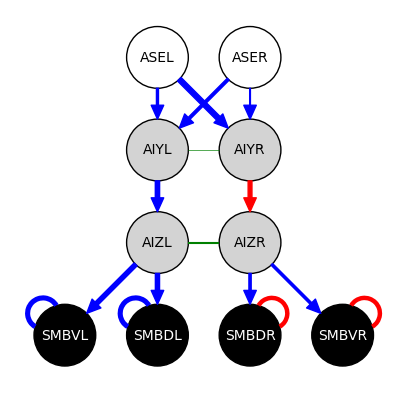

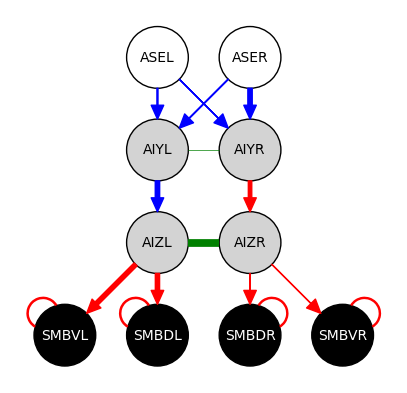

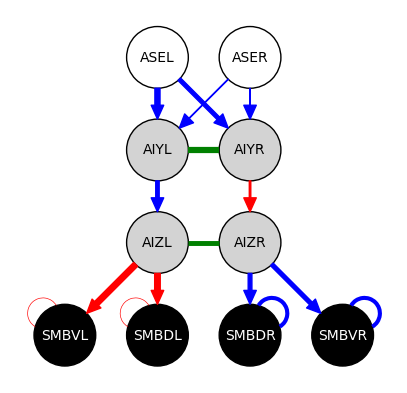

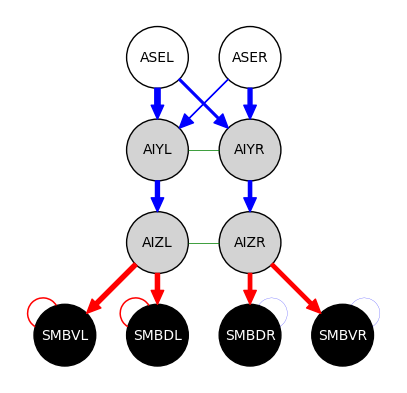

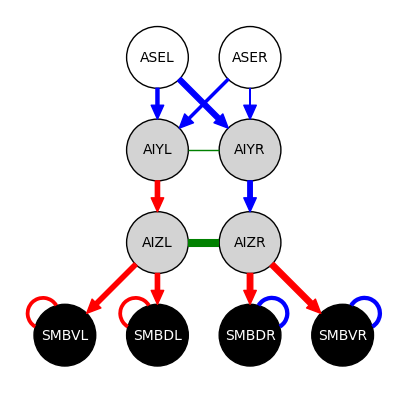

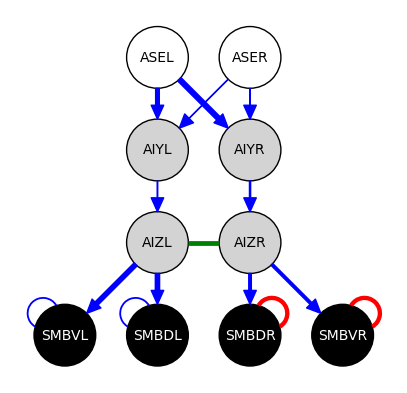

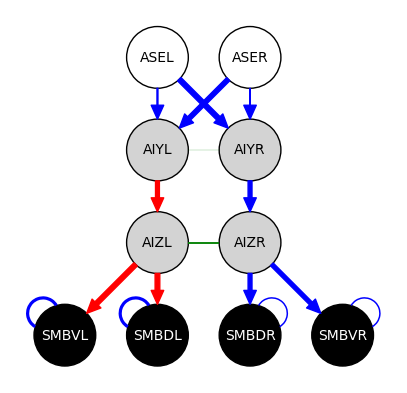

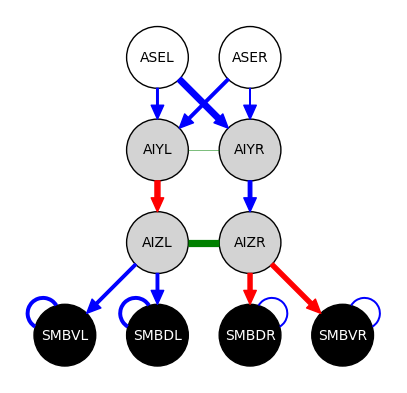

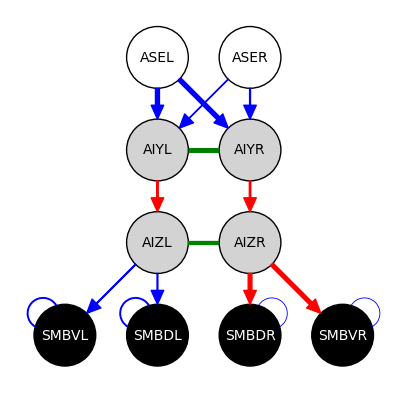

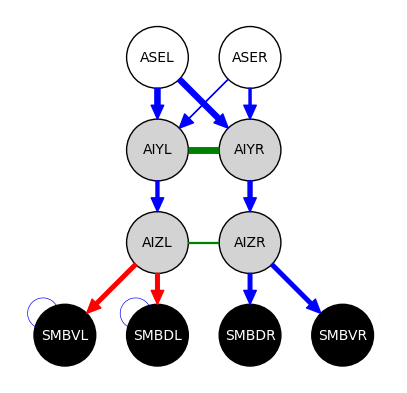

In [3]:
result = load.load_result_json("../result/Result_biologically_correct.json")
file_path_base = "../figure/connectome/connectome_"
for i in range(10):
    gene = result[i]["gene"]
    file_path = file_path_base + str(i)
    figure.connectome(gene, file_path)

In [ ]:
result = load.load_result_json("../result/Result_biologically_correct.json")
file_path_base = "../figure/newron/newron_"
for i in range(10):
    gene = result[i]["gene"]
    file_path = file_path_base + str(i)
    figure.newron_output(gene, file_path)

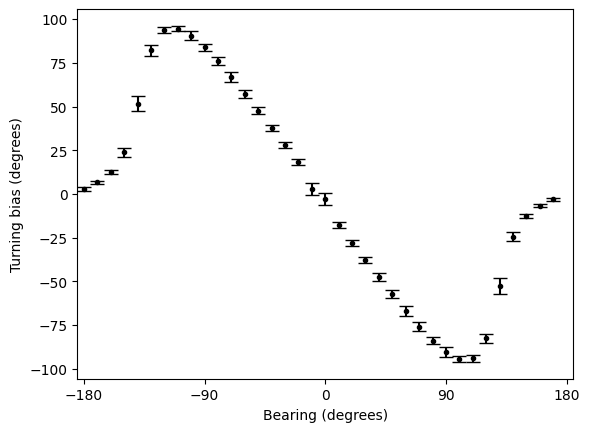

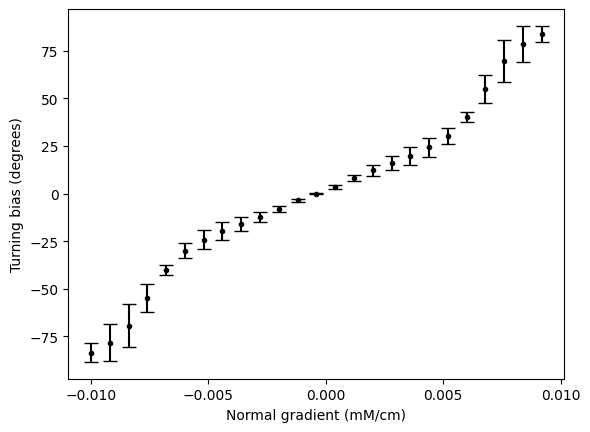

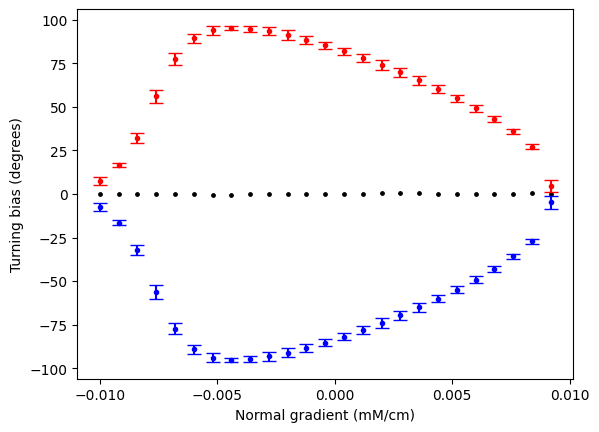

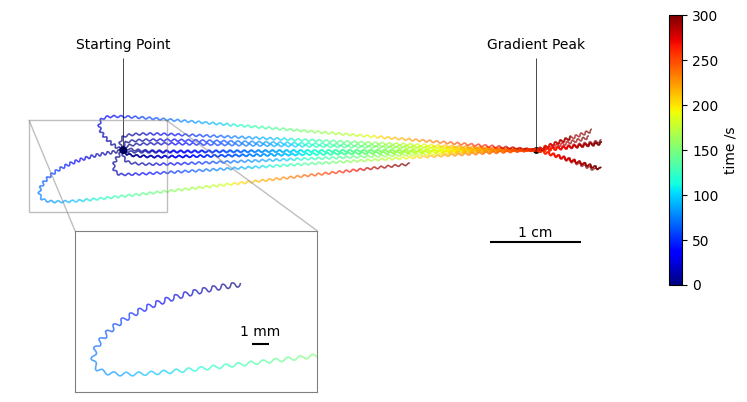

In [6]:
figure.Bearing_vs_Turing_bias(
    "../output/b_vs_t_bc.txt", "../figure/Bearing_vs_Turing_bias_bc.png"
)

figure.Normal_gradient_vs_Turing_bias(
    "../output/n_vs_t_bc.txt", "../figure/Normal_gradient_vs_Turing_bias_bc.png"
)

figure.Translational_gradient_vs_Turing_bias(
    "../output/t_vs_t_bc.txt", "../figure/Translational_gradient_vs_Turing_bias_bc.png"
)

figure.trajectory(gene, 10, 7, "../figure/Trajectory_colorbar_bc.png")